**Modeling growth and propagation of bacterial colonies on flat surfaces.**

This protocol replicates the main text protocol that simulates demographic noise which causes spatial segregation of expanding, equally-fit colonies. 

In [1]:
import cobra
import cobra.test # for the ijo1366 model
import sys
import copy
import numpy as np
sys.path.append("/home/jeremy/Dropbox/work_related/harcombe_lab/segre/cometspy")
import cometspy as c

We will use the E. coli core model.

In [2]:
ecoli = cobra.test.create_test_model("textbook")

We will now convert this into a COMETS model, and set two parameter options: the demographic noise parameter, which is called "neutral drift," and convection-based motion parameters. 

In [10]:
grid_size = 40
ecoli_comets = c.model(ecoli)
ecoli_comets.reactions.loc[ecoli_comets.reactions.EXCH, "LB"] = -1000
ecoli_comets.add_nonlinear_diffusion_parameters(convNonlinDiffZero = 0.,
                                    convNonlinDiffN = 6.e-6,
                                    convNonlinDiffExponent = 1.0,
                                    convNonlinDiffHillN = 2.,
                                    convNonlinDiffHillK = 0.001)
ecoli_comets.add_neutral_drift_parameter(0.01)

Note: for non-linear diffusion parameters to function,
params.all_params['biomassMotionStyle'] = 'ConvNonlin' Diffusion 2D'
must also be set


Let's make an exact copy of the ecoli comets model.

In [31]:
import random

ecoli_comets2 = copy.copy(ecoli_comets)
ecoli_comets2.id = "e_coli_core2"

ecoli_comets.initial_pop = [[x, 0, np.random.normal(6.4e-5, 1e-6)] for x in range(grid_size)]
ecoli_comets2.initial_pop = [[x, 0, np.random.normal(6.4e-5, 1e-6)] for x in range(grid_size)]


This simulation will be of a single, centered colony on a 100x100 grid. carbon will be spread homogenously, and be fixed at initial concentration along one end.

In [32]:
ly = c.layout([ecoli_comets, ecoli_comets2])
ly.grid = [grid_size, grid_size]
ly.set_specific_metabolite("glc__D_e", 2.2e-3)
ly.set_specific_metabolite("h2o_e", 1000)
ly.set_specific_metabolite("nh4_e", 1000)
ly.set_specific_metabolite("o2_e", 1000)
ly.set_specific_metabolite("pi_e", 1000)
ly.set_specific_metabolite("h_e", 1000)

for x in range(grid_size):
    ly.set_specific_static_at_location("glc__D_e", (x, grid_size-1), 1.1e-3)
    

The main parameter we need to set is biomassmotionstyle, which must be set to "ConvNonlin Diffusion 2D".  Then, to capture the spatial information, we'll also log biomass (instead of just total biomass). Finally, we'll also adjust a handful of other parameters. These are stored in the dictionary all_params.

In [33]:
p = c.params()

cycles = 1000

p.all_params["biomassMotionStyle"] = "ConvNonlin Diffusion 2D"
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = cycles
p.all_params["maxCycles"] = cycles
p.all_params["timeStep"] = 0.05
p.all_params["spaceWidth"] = 0.01
p.all_params["defaultDiffConst"] = 6.e-6
p.all_params["maxSpaceBiomass"] = 1000000
p.all_params["minSpaceBiomass"] = 1.0e-9
p.all_params["allowCellOverlap"] = True
p.all_params["growthDiffRate"] = 0
p.all_params["defaultVmax"] = 18.5
p.all_params["defaultKm"] = 0.000015
p.all_params["defaultHill"] = 1
p.all_params["exchangestyle"] = "Monod Style"

Now we make a simulation object and run it.  This can take awhile.

In [34]:
sim = c.comets(ly, p)
# this should all be removable once the installer is made with dependencies in a predictable location
sim.set_classpath("concurrent", "/opt/colt/lib/concurrent.jar")
sim.set_classpath("colt", "/opt/colt/lib/colt.jar")
sim.set_classpath("lang3", "/opt/commons-lang3-3.9/commons-lang3-3.9.jar")
sim.set_classpath("jmatio","/opt/jmatio/lib/jmatio.jar")
sim.set_classpath("math3","/opt/commons-math3-3.6.1/commons-math3-3.6.1.jar")
sim.set_classpath("bin","/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_2.10.0.jar")
sim.set_classpath("gurobi","/opt/gurobi900/linux64/lib/gurobi.jar")
sim.set_classpath("jdistlib", "/opt/jdistlib-0.4.5-bin.jar")
sim.run(False)

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
gurobi			/opt/gurobi900/linux64/gurobi.jar
junit			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/junit-4.12.jar
hamcrest			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/hamcrest-core-1.3.jar
jogl_all			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio			/Dropbox/work_related/harcombe_lab/segre/comets

Now let's plot the results. We use the get_biomass_image helper function and then matplotlib to do the plotting.

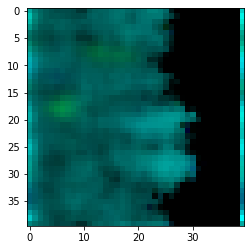

In [38]:
im = sim.get_biomass_image('e_coli_core', cycles).astype(float)
im = im / np.max(im)
im2 = sim.get_biomass_image('e_coli_core2',cycles).astype(float)
im2 = im2 / np.max(im2)
final = np.zeros((grid_size,grid_size,3))
final[:,:,1] = im
final[:,:,2] = im2
from matplotlib import pyplot as plt
plt.imshow(final)